# Introduction to Algorithmic Trading in Python

## Definition of Algorithmic Trading

Algorithmic trading is a method of executing orders using automated pre-programmed trading instructions accounting for variables such as time, price, and volume. This type of trading attempts to leverage the speed and computational resources of computers relative to human traders. In the twenty-first century, algorithmic trading has been gaining traction with both retail and institutional traders. 

It is widely used by investment banks, pension funds, mutual funds, and hedge funds that may need to spread out the execution of a larger order or perform trades too fast for human traders to react to. A study in 2019 showed that around 92% of trading in the Forex market was performed by trading algorithms rather than humans.

The term algorithmic trading is often used synonymously with automated trading system. These encompass a variety of trading strategies, some of which are based on formulas and results from mathematical finance, and often rely on specialized software.

Source : Wikipedia :)

## Strategy 1 : Bollinger Bands and Relative Strength Index (RSI)

### Mathematical background

#### Bollinger Bands

Let $x$ be serie of prices (generally closing price)

Here are the steps to follow to calculate the Bollinder Bands:

* Calculate the Moving Average over *n* period of x
$$\mu = \frac{1}{n} \sum_{i}^n x_i $$
* Calculate the standard deviation as follow :
$$\sigma = \sqrt{\frac{1}{n} \sum_{i}^n (x_i - \mu)^2} $$
* Upper Band is :
$$ \mu + \delta \sigma $$
* Lower Band is :
$$ \mu - \delta \sigma $$

$ \delta $ parameter could be adapte based on the analysis (1.5, 2, 2.5, ..)

##### Interpreation and use

The purpose of Bollinger Bands is to provide a relative definition of high and low prices of a market. By definition, prices are high at the upper band and low at the lower band.

The use of Bollinger Bands varies widely among traders. Some traders buy when price touches the lower Bollinger Band and exit when price touches the moving average in the center of the bands. Other traders buy when price breaks above the upper Bollinger Band or sell when price falls below the lower Bollinger Band.

#### Relative Strength Index

$$RSI = \frac{U(n)}{U(n) + D(n)} \times (100) $$

where :
* U : Exponential smoothed moving average of n-period of upward change 
* D : Exponential smoothed moving average of n-period of downward change 
* n : Period of moving average

##### Interpreation and use

Traditionally, RSI readings greater than the 70 level are considered to be in overbought territory, and RSI readings lower than the 30 level are considered to be in oversold territory. In between the 30 and 70 level is considered neutral, with the 50 level a sign of no trend.

### Implementation

In [98]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt

In [195]:
def Strategy_1(ticker, start, end, bb_period, rsi_period, stop_loss = False, SL = 0):
    
    df = yf.download(ticker, start = start, end = end)
    df['ma_20'] = df.Close.rolling(bb_period).mean()
    df['vol'] = df.Close.rolling(bb_period).std()
    df['upper_bb'] = df.ma_20 + (2*df.vol)
    df['lower_bb'] = df.ma_20 - (2*df.vol)
    df['rsi'] = ta.momentum.rsi(df.Close, window = rsi_period)
    
    conditions = [(df.rsi < 300) & (df.Close < df.lower_bb),
             (df.rsi > 70) & (df.Close > df.upper_bb)]
    choices = ['Buy', 'Sell']
    
    df['signal'] = np.select(conditions, choices)
    df.dropna(inplace = True)
    
    df.signal = df.signal.shift()
    df['shifted_Close'] = df.Close.shift()
    
    position = False
    buydates, selldates = [], []
    buyprices, sellprices = [], []

    for index, row in df.iterrows():
        if not position and row['signal'] == 'Buy':
            buydates.append(index)
            buyprices.append(row.Open)
            position = True
        
        if position:
            if stop_loss:
                if row['signal'] == 'Sell' or row.shifted_Close < SL * buyprices[-1]:
                    selldates.append(index)
                    sellprices.append(row.Open)
                    position = False
            else:
                if row['signal'] == 'Sell':
                    selldates.append(index)
                    sellprices.append(row.Open)
                    position = False
            
            
    output = {'df' : df,
              'buydates' : buydates,
              'buyprices' : buyprices, 
              'selldates' : selldates, 
              'sellprices' : sellprices}
    return output
    

In [196]:
def Performance_calculator(buyprices, sellprices):
    rtn = (pd.Series([(sell - buy) / buy for sell, buy in zip(sellprices, buyprices)]) + 1).prod() - 1
    print(f"This Strategy gave you {round(rtn, 4) * 100} % of return")

In [197]:
start_SQ = Strategy_1(ticker = 'SQ', start = '2019-01-01', end = '2022-08-13',  bb_period = 20, rsi_period = 6, 
                      stop_loss = False)

start_SQ_SL_5 = Strategy_1(ticker = 'SQ', start = '2019-01-01', end = '2022-08-13',  bb_period = 20, rsi_period = 6, 
                         stop_loss = True, SL = 0.95)

start_SQ_SL_10 = Strategy_1(ticker = 'SQ', start = '2019-01-01', end = '2022-08-13',  bb_period = 20, rsi_period = 6, 
                         stop_loss = True, SL = 0.90)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

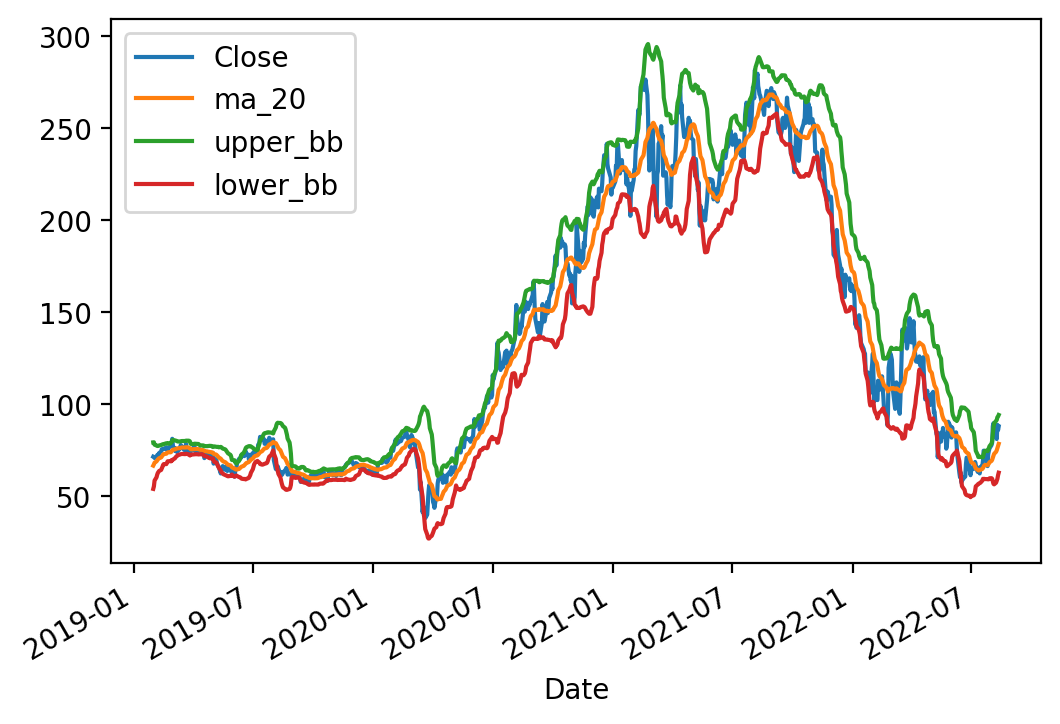

In [198]:
start_SQ['df'][['Close', 'ma_20', 'upper_bb', 'lower_bb']].plot()

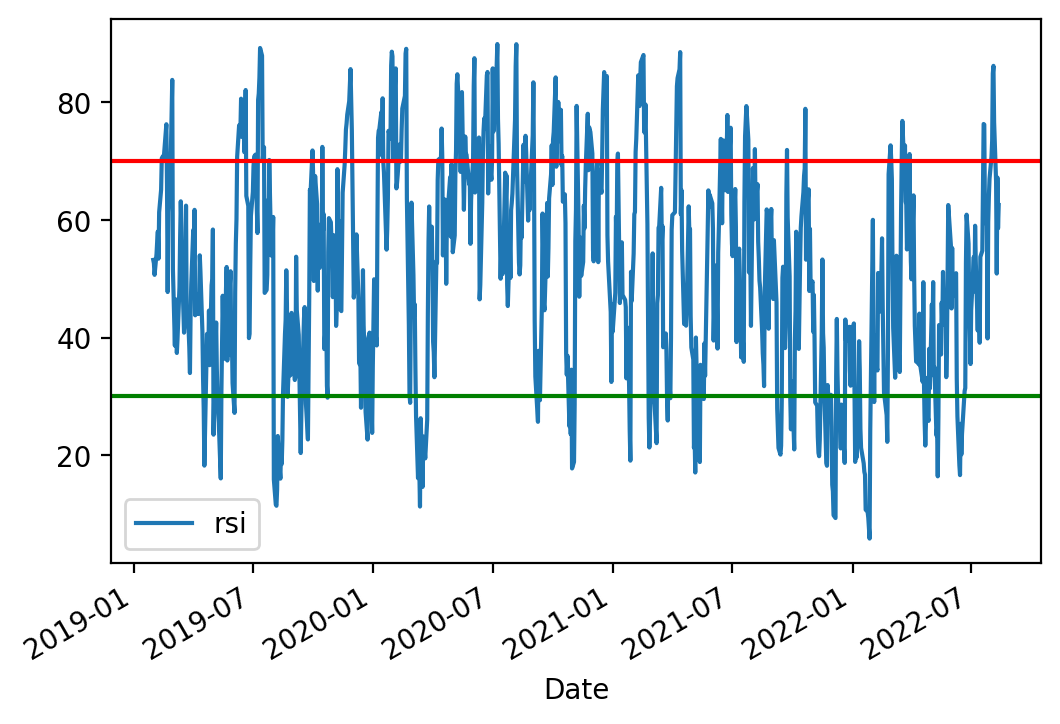

In [199]:
start_SQ['df'][['rsi']].plot()
plt.axhline(y = 70, color = 'r', linestyle = '-')
plt.axhline(y = 30, color = 'g', linestyle = '-')

In [200]:
start_SQ['df'].index

DatetimeIndex(['2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04',
               '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
               '2019-02-11', '2019-02-12',
               ...
               '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
               '2022-08-05', '2022-08-08', '2022-08-09', '2022-08-10',
               '2022-08-11', '2022-08-12'],
              dtype='datetime64[ns]', name='Date', length=892, freq=None)

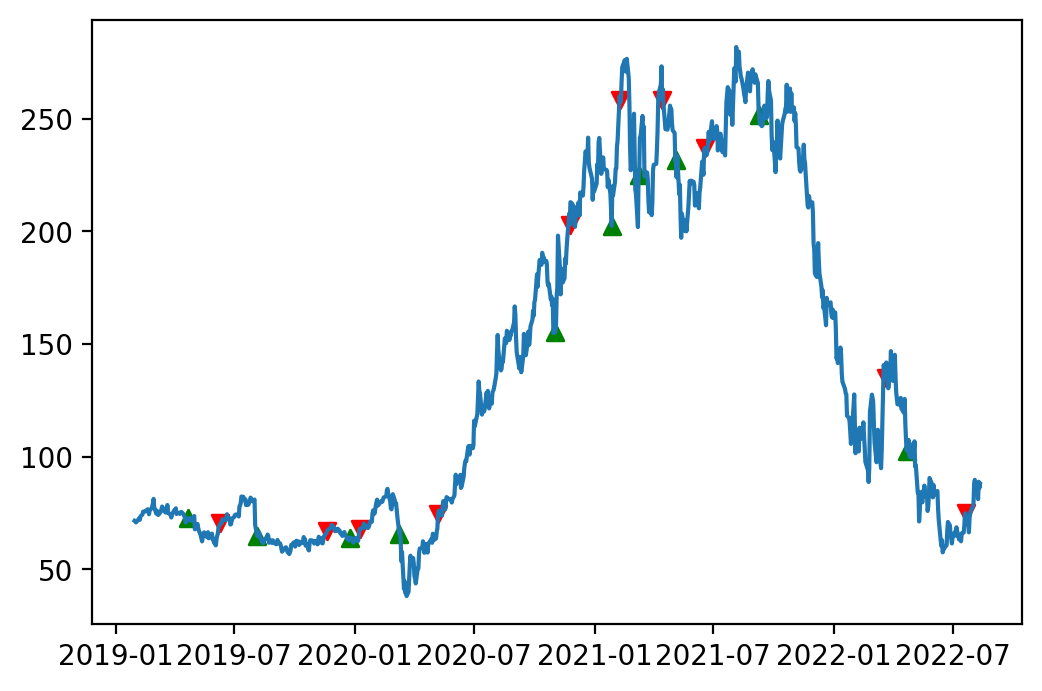

In [201]:
plt.plot(start_SQ['df'].Close)
plt.scatter(start_SQ['df'].loc[start_SQ['buydates']].index,
                start_SQ['df'].loc[start_SQ['buydates']].Close,
                marker = '^', c = 'g')
plt.scatter(start_SQ['df'].loc[start_SQ['selldates']].index,
                start_SQ['df'].loc[start_SQ['selldates']].Close,
                marker = 'v', c = 'r')

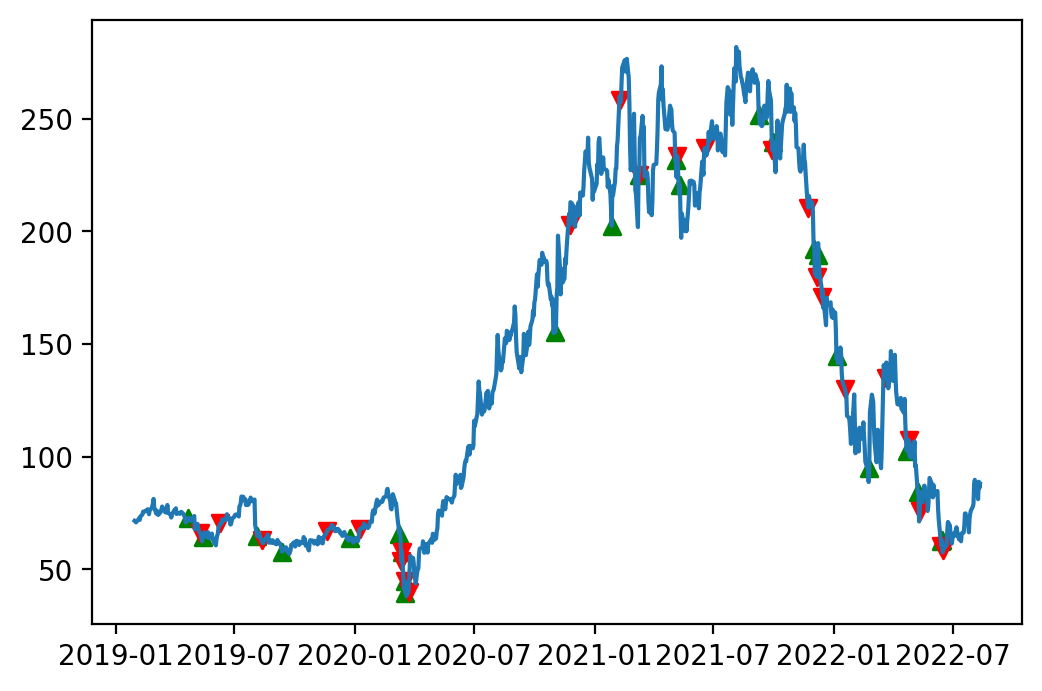

In [202]:
plt.plot(start_SQ_SL_5['df'].Close)
plt.scatter(start_SQ_SL_5['df'].loc[start_SQ_SL_5['buydates']].index,
                start_SQ_SL_5['df'].loc[start_SQ_SL_5['buydates']].Close,
                marker = '^', c = 'g')
plt.scatter(start_SQ_SL_5['df'].loc[start_SQ_SL_5['selldates']].index,
                start_SQ_SL_5['df'].loc[start_SQ_SL_5['selldates']].Close,
                marker = 'v', c = 'r')

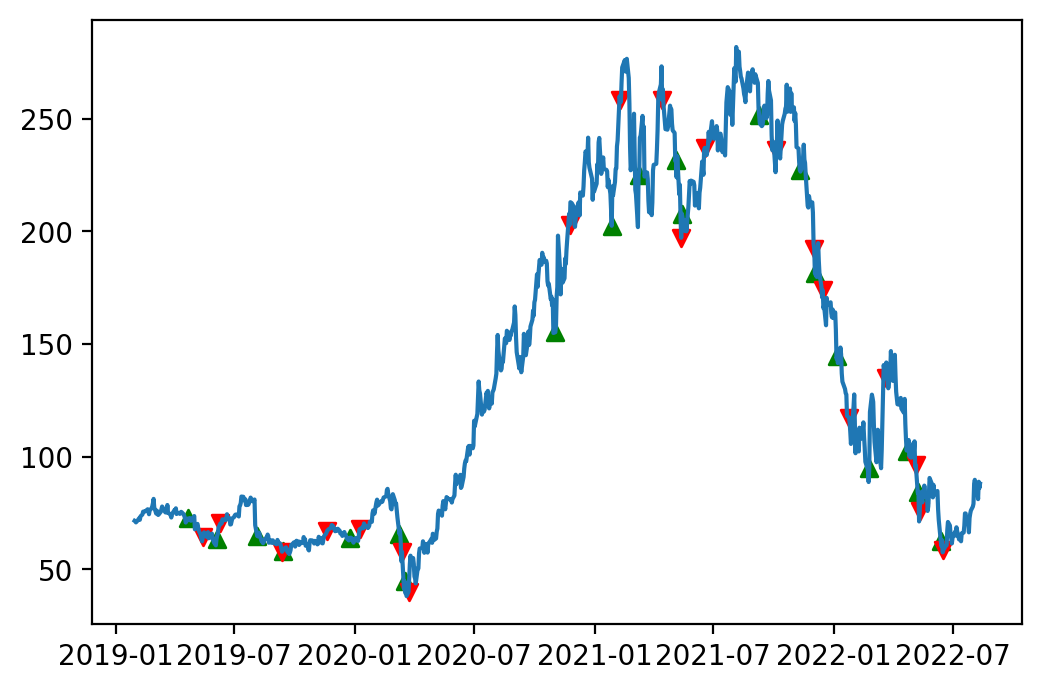

In [203]:
plt.plot(start_SQ_SL_10['df'].Close)
plt.scatter(start_SQ_SL_10['df'].loc[start_SQ_SL_10['buydates']].index,
                start_SQ_SL_10['df'].loc[start_SQ_SL_10['buydates']].Close,
                marker = '^', c = 'g')
plt.scatter(start_SQ_SL_10['df'].loc[start_SQ_SL_10['selldates']].index,
                start_SQ_SL_10['df'].loc[start_SQ_SL_10['selldates']].Close,
                marker = 'v', c = 'r')

In [204]:
Performance_calculator(start_SQ['buyprices'], start_SQ['sellprices'])
Performance_calculator(start_SQ_SL_5['buyprices'], start_SQ_SL_5['sellprices'])
Performance_calculator(start_SQ_SL_10['buyprices'], start_SQ_SL_10['sellprices'])

This Strategy gave you -14.08 % of return
This Strategy gave you 24.33 % of return
This Strategy gave you -1.1400000000000001 % of return
